# Model project

This project examine the OLG model with PAYG system. The model will be analysed analytically and numerically. Furthermore the effect of a change in tax will be analysed in steady state. 

In [27]:
# Import python modules
import numpy as np
from scipy import optimize
import sympy as sm
from types import SimpleNamespace
import matplotlib.pyplot as plt
import ipywidgets as widgets

# Autoreload modules when code is run
%load_ext autoreload
%autoreload 2

# Import local modules
import Analysis as ay
import numerical as nm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### The construction of the model

We are examining an economy with a constant population growth rate, $n>0$, where individuals live for two periods. During period $t$ individuals work and save their money, and in periode $t+1$ they live off their savings. Furthermore the market consist of identical competitive firms that maximizes their profit using Cobb-Douglas technology. Their production function therefore combines labor, $L_t$, and capital, $K_t$, such that $Y= A K_t^\alpha L_t^{(1-\alpha)}$, with $\alpha\in(0,1)$. Finally full capital depreciation is assumed. Profit maximization leads to further equations:
$$r_t = \alpha A k_t^{(\alpha-1)},$$
$$w_t = (1-\alpha)A k_t^\alpha,$$
where $r_t$ denotes the rental rate of capital, $w_t$ denotes the wage rate, and $k_t$ denotes capital per worker. 


The individuals born in period $t$ have further utility function:
$$U_t = \ln c_{1t} + \beta \ln c_{2t+1},$$
where $0 < \beta < 1$. 
The parameter $c_{1t}$ denotes consumption when young, and $c_{2t+1}$ denotes consumption when old. The young individuals use all their time endowment working, which is therefore set to 1. The goverment runs a social security system which in place is an unfunded pay-as-you-go system where the young individuals make contributions to the current old generation. The young individuals therefore pays a contribution $d$ of thair wages. The parameter $d$ is then given by $d_t = \tau w_t $ where $\tau \in (0,1)$. The contributions are payed to the old generation in the same period, and their consumption is therefore sustained by their savings and the contributions. The budget constraints in the two periods of life are therefore given by:
$$c_{1t}+s_t = (1-\tau)w_t,$$
$$c_{2t+1} = (1+r_{t+1})s_t + (1+n) d_{t+1}.$$

Because it is only the young generation that saves money, the capital accumulation is given by:
$$K_{t+1}=s_t(w_t,(1+r_{t+1}))L_t \Leftrightarrow k_{t+1} = \frac{s_t(w_t,(1+r_{t+1}))}{1+n}$$

### Analytical analysis

In this section the Eulers equation is found and used to find the optimal level of saving. Furthermore the expression for saving is used to find the capital accumulation. Finally the steady state level of capital is found by the capital accumulation.


In [28]:
# a. Importing the class from modelproject.py
model_a = ay.AnalysismodelclassOLG()
par = model_a.par

The Euler equation indicates the optimal path of consumption. We find the Euler equation by solving the problem of savings, which is given by the following: 
$$\max_{c_{1t}, c_{2t+1}} \ln c_{1t} + \beta \ln c_{2t+1},$$
where the two secondary conditions is given by the consuption functions for the young and the old generation:
$$c_{1t}+s_t = (1-\tau)w_t,$$
$$c_{2t+1} = (1+r_{t+1})s_t + (1+n) d_{t+1}.$$

In [29]:
print('First we find the utility function by lagrange')
display(sm.Eq(par.U_t, model_a.utilityfunc()))
print('We now find the intertemporal budget constraint that shows the relationship between consumption in period t and t+1')
display(sm.Eq(0, model_a.budgetcon()))
print('Finally we find the Euler equation')
model_a.eulereq()

First we find the utility function by lagrange


Eq(U_t, log(c_1t) + log(c_{2t+1})/(rho + 1))

We now find the intertemporal budget constraint that shows the relationship between consumption in period t and t+1


Eq(0, -w_t*(1 - tau) + (c_1t*r_{t+1} + c_1t + c_{2t+1} - n*tau*w_{t+1} - tau*w_{t+1})/(r_{t+1} + 1))

Finally we find the Euler equation


Eq(c_{2t+1}*(rho + 1)/(r_{t+1} + 1), c_1t)

We now insert the equations for $c_{1t}$ and $c_{2t+1}$ into the Euler equation. This gives an expression for the optimal saving for period t, that only depends on the rental rate of capital and the wage rate.

In [30]:
display(sm.Eq(par.s_t, model_a.optimalsave()))

Eq(s_t, (w_t*(-r_{t+1}*tau + r_{t+1} - tau + 1) + w_{t+1}*(-n*rho*tau - n*tau - rho*tau - tau))/(r_{t+1}*rho + 2*r_{t+1} + rho + 2))

We now want to find the capital accumulation. This is done by inserting the expression for savings into the capital law of motion. 

In [31]:
model_a.capitalacc()

We find the capital accumulation to be given by


Eq(k_{t+1}, A*k_t**alpha*(1 - alpha)*(1 - tau)/((1 + tau*(1 - alpha)*(rho + 1)/(alpha*(rho + 2)))*(n + 1)*(rho + 2)))

To find the steady state level of capital we insert $k^*=k_t=k_{t+1}$ in the capital accumulation. We furthermore expect the parameters to have the estimates below.

In [32]:
# a. Defining parameter values 
alpha2 = 1/3
rho = 0.25
n2 = 0.01
tau2 = 0.25
A_tec_2 = 20

# b. Finding  and printing the analytical solution 
kstar_function = sm.lambdify(args = (par.alpha, par.rho, par.n, par.tau, par.A), expr=model_a.cap_steadystate())

# c. Printing the solution
print('The steady state of capital is then given by:')
kstar_function(alpha2,rho,n2,tau2,A_tec_2)

The steady state is found to be:


Eq(k^*, (A*(1 - alpha)*(1 - tau)/((1 + tau*(1 - alpha)*(rho + 1)/(alpha*(rho + 2)))*(n + 1)*(rho + 2)))**(1/(1 - alpha)))

The steady state of capital is then given by:


6.390887399044313

### Numerical analysis

We now use our results from the analytical analysis to find the steady state level of capital given different values of the parameters. We will use numerical optimization to find the steady state levels and present the solutions in a transition diagram.

/Users/frederikkebogebladlarsen/projects-2023-frederikke-x2-og-sofie-7/modelproject/numerical.py:208: RuntimeWarning: overflow encountered in double_scalars
  dev = (k_tnext - s_t / (1 + self.n))**2  # 3. The deviation that should be minimized is defined
/Users/frederikkebogebladlarsen/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2131: RuntimeWarning: invalid value encountered in double_scalars
  r = (xf - nfc) * (fx - ffulc)
/Users/frederikkebogebladlarsen/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2132: RuntimeWarning: invalid value encountered in double_scalars
  q = (xf - fulc) * (fx - fnfc)
/Users/frederikkebogebladlarsen/projects-2023-frederikke-x2-og-sofie-7/modelproject/numerical.py:111: RuntimeWarning: overflow encountered in double_scalars
  w_t = self.y(k_t) - self.y_prime(k_t) * k_t


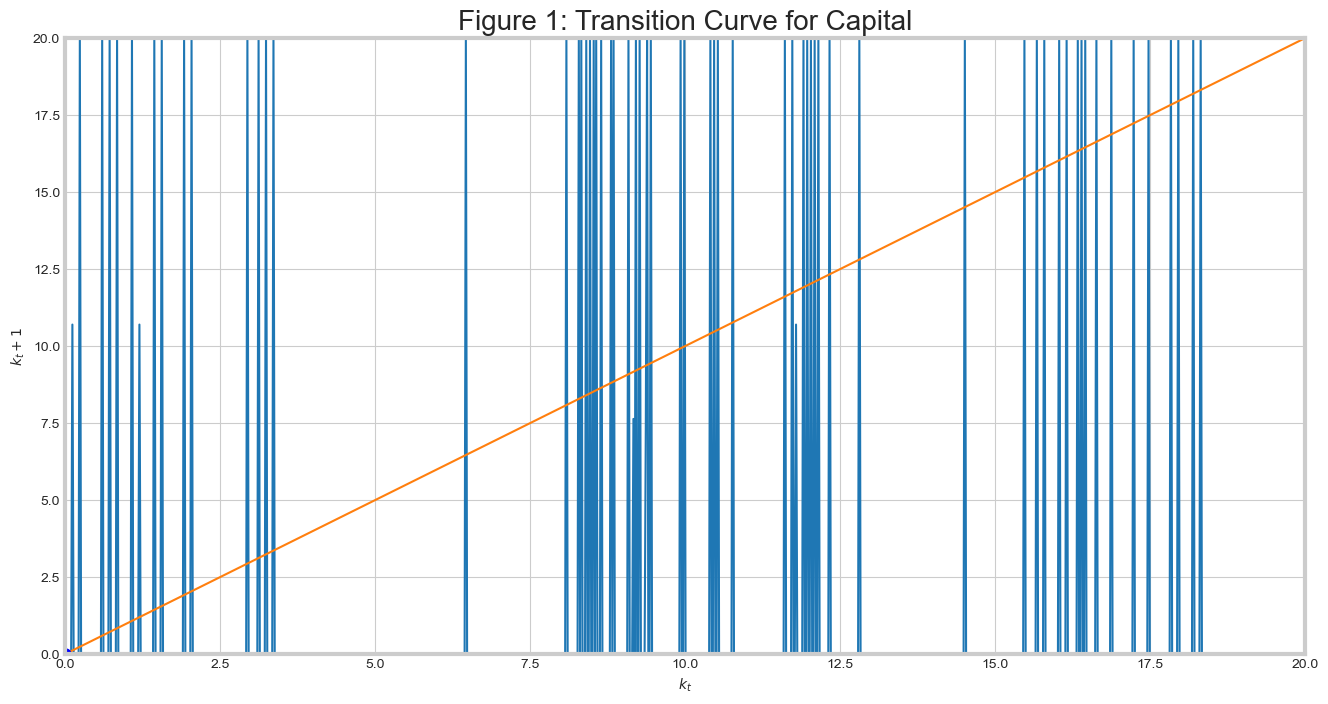

In [33]:
# a. The OLG class is called
model_n = nm.NumericalmodelclassOLG()
         
# b. Plotting the optimal level of capital in the transition diagram

# i. The function describing the transition curve is called    
model_n.numericaltransition_curve()

# ii. The figure is called and defined
figure = plt.figure(figsize=(16,8))
ax = figure.add_subplot(1,1,1)

# iii. From the module, num_class, the graphs of the transition diagram are called
model_n.plot_numericaltransition_curve(ax)
model_n.plot_numerical45_curve(ax)
plt.plot(model_n.ss, model_n.ss, 'o', markersize=8, color='blue')
plt.annotate(f'$k^*$ = {model_n.ss:.3f}', (model_n.ss-2, model_n.ss+1), size=12)
plt.title('Figure 1: Transition Curve for Capital', loc='center', size=20)
ax.spines['bottom'].set_linewidth(3)
ax.spines['top'].set_linewidth(3)
ax.spines['right'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)

# iv. Display figure
plt.show()

It is shown from the transition curve that capital is equal to 6.377 in equlibrium. The solution is found by numerical optimization which explains the difference from the result in the analytical analysis. 

The steady state levels with different parameter values is now found. We define the baseline values and make a menu to vary the values of the parameters. 

In [34]:
# a. Constructing the steady state function included flexible parameter values
def steadystate(A, alpha, rho, n, tau):
    output = kstar_function(A, alpha, rho, n, tau)
    print(f'Given the chosen parameter values the steady state value of capital per capita is given by: {output:.3f}')
    
# b. Baseline parameter values
alpha2 = 1/3
rho2 = 0.25
n2 = 0.01
tau2 = 0.25
A2 = 20 

In [35]:
# Showing a widget slider
widgets.interact(
        steadystate, 
        A = widgets.FloatSlider(description="A", min=0, max=100, step=0.01, value=A2, continuous_update=False),  
        alpha = widgets.FloatSlider(description="alpha", min=0.01, max=0.99, step=0.01, value=alpha2, continuous_update=False),
        rho = widgets.FloatSlider(description="rho", min=0, max=0.99, step=0.01, value=rho2,  continuous_update=False),
        n = widgets.FloatSlider(description="n", min=-0.99, max=0.99, step=0.01, value=n2, continuous_update=False),    
        tau = widgets.FloatSlider(description="tau", min=0, max=0.99, value=tau2, step=0.01, continuous_update=False)

)

interactive(children=(FloatSlider(value=20.0, continuous_update=False, description='A', step=0.01), FloatSlide…

<function __main__.steadystate(A, alpha, rho, n, tau)>

We now want to examine what happens to the steady state with different levels of taxes. We use a OLG model and plot the results into the transition diagram. 

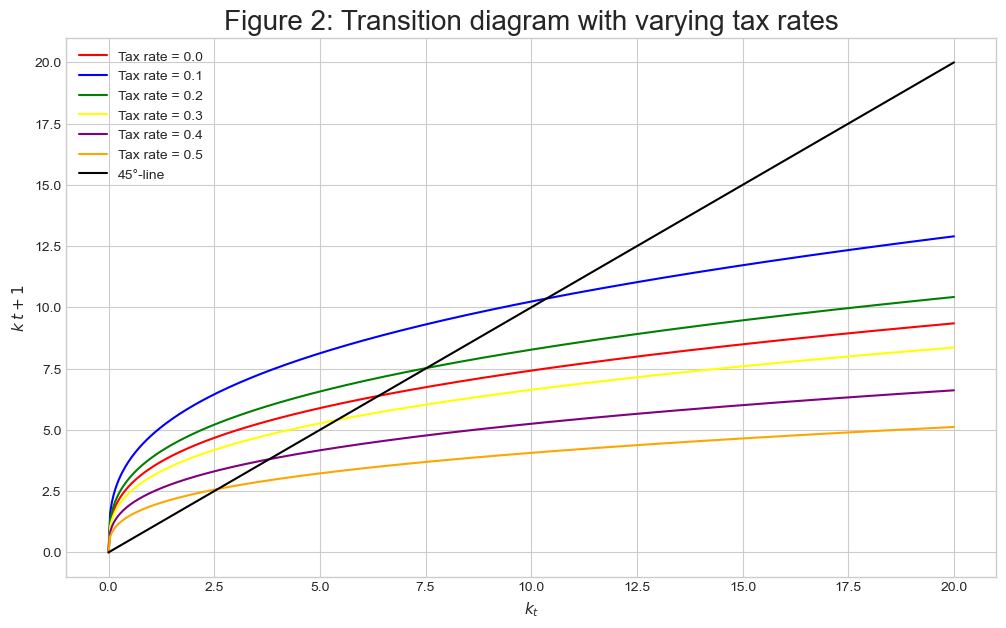

In [36]:
# a. Graphic presentation of the transition curve 
def plot_steadystate(k_t, alpha, rho, n, A, tau):                                
    return (alpha*(1/(1+rho))*A*k_t**alpha*(alpha*tau-alpha-tau+1))/(alpha*(1/(1+rho))*n+alpha*(1/(1+rho))-alpha*tau*n+alpha*n-alpha*tau+alpha+ n*tau+tau)

# b. Defining capital in each period and differing value of tax rates
k_t = np.linspace(0,20,500)
tau3=0.1
tau4=0.2
tau5=0.3
tau6=0.4
tau7=0.5


# c. Plot and display figure
fig = plt.figure(figsize = (12,7))
ax = fig.add_subplot(1,1,1)
plt.plot(k_t, plot_steadystate(k_t, alpha2, rho2, n2, A2, tau2), 'r') 
plt.plot(k_t, plot_steadystate(k_t, alpha2, rho2, n2, A2, tau3), 'b') 
plt.plot(k_t, plot_steadystate(k_t, alpha2, rho2, n2, A2, tau4), 'g')
plt.plot(k_t, plot_steadystate(k_t, alpha2, rho2, n2, A2, tau5), 'yellow')
plt.plot(k_t, plot_steadystate(k_t, alpha2, rho2, n2, A2, tau6), 'purple')
plt.plot(k_t, plot_steadystate(k_t, alpha2, rho2, n2, A2, tau7), 'orange')
plt.plot(k_t,k_t, 'black' )
plt.title('Figure 2: Transition diagram with varying tax rates', fontsize=20)
plt.legend(('Tax rate = 0.0', 'Tax rate = 0.1','Tax rate = 0.2','Tax rate = 0.3','Tax rate = 0.4', 'Tax rate = 0.5', '45\N{DEGREE SIGN}-line'), loc='upper left')
plt.xlabel('$ k_t $', fontsize=11)
plt.ylabel( '$ k_ {t + 1} $', fontsize=11)

plt.grid(True)
plt.show()

### Conclusion

This project has analysed an economy consisting of 2 periods analytically and numerically. The economy has been solved through a OLG model with PAYG system. The analytical and numerical analysis showed approximately the same results for the steady state value of capital. Furthermore the project has analysed the development of the steady state of capital given different parameter values. A higher non negative tax rate on income will cause a lower steady state value of capital per capita. 